# Masked Token Prediction with Vision
We test the five pretrained models with some images here.

In [1]:
import torch
import numpy as np
import PIL.Image

from eval_vl_glue import VoltaImageFeature
from eval_vl_glue.extractor import BUTDDetector
from eval_vl_glue import transformers_volta

from IPython.display import display

## Model setup

In [2]:
device = torch.device('cuda:0')
# faster than on cpu, but around 15GB VRAM will be consumed.

In [3]:
# extractor
model_path = '../download/resnet101_faster_rcnn_final_iter_320000.pt'
extractor = BUTDDetector()
extractor.load_state_dict(torch.load(model_path))
extractor = extractor.eval().to(device)

In [4]:
# V&L transformer
model_paths = [
    '../vl_models/pretrained/ctrl_visual_bert',
    '../vl_models/pretrained/ctrl_uniter',
    '../vl_models/pretrained/ctrl_vl_bert',
    '../vl_models/pretrained/ctrl_vilbert',
    '../vl_models/pretrained/ctrl_lxmert',
]
models = []
for model_path in model_paths:
    tokenizer = transformers_volta.AutoTokenizer.from_pretrained(model_path)
    model = transformers_volta.AutoModelForMaskedLM.from_pretrained(model_path)
    model = model.eval().to(device)
    models.append((model_path.split('/')[-1], model, tokenizer))

Some weights of the model checkpoint at ../vl_models/pretrained/ctrl_visual_bert were not used when initializing VoltaForMaskedLM: ['cls.bi_seq_relationship.weight', 'cls.bi_seq_relationship.bias', 'cls.imagePredictions.transform.dense.weight', 'cls.imagePredictions.transform.dense.bias', 'cls.imagePredictions.transform.LayerNorm.weight', 'cls.imagePredictions.transform.LayerNorm.bias', 'cls.imagePredictions.decoder_dict.0.weight', 'cls.imagePredictions.decoder_dict.0.bias']
- This IS expected if you are initializing VoltaForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing VoltaForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at ../vl_models/

## Test data

In [5]:
image_paths = [
    '../download/000002.jpg',
    '../download/000004.jpg',
    '../download/000542.jpg',
    '../download/000362.jpg',
    '../download/filled_with_0.png', # the same as default image
    '../download/filled_with_255.png',
]
images = [PIL.Image.open(_) for _ in image_paths]
text = 'I can see a [MASK].'

## Masked Token Prediction 

In [6]:
# image and text -> top 10 predicted tokens
def predict(model, tokenizer, image, text, top_k=10):
    x_image = VoltaImageFeature.from_regions(extractor.detect(image))
    x_text = tokenizer(text)
    
    with torch.no_grad():
        outputs = model(
             torch.tensor(x_text['input_ids']).to(device)[None], 
            x_image.features.to(device)[None], 
            x_image.image_location.to(device)[None]
        )
        # None accounts for batch axis
    
    mask_pos = x_text['input_ids'].index(tokenizer.mask_token_id)
    return tokenizer.convert_ids_to_tokens(outputs.logits[0, mask_pos].argsort(descending=True)[:top_k].cpu().numpy())

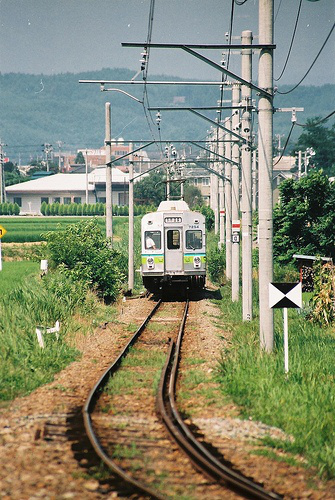

text: I can see a [MASK].


/data/eval_vl_glue/venv/lib/python3.6/site-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/data/eval_vl_glue/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


- ctrl_visual_bert [MASK]=['train', 'city', 'locomotive', 'tram', 'view', 'railway', 'car', 'photograph', 'bridge', 'rainbow']
- ctrl_uniter [MASK]=['train', 'city', 'tram', 'view', 'locomotive', 'sign', 'bridge', 'difference', 'lot', 'railway']
- ctrl_vl_bert [MASK]=['train', 'city', 'view', 'tram', 'locomotive', 'rainbow', 'railway', 'picture', 'lot', 'railroad']
- ctrl_vilbert [MASK]=['train', 'city', 'tram', 'locomotive', 'view', 'railway', 'rainbow', 'sign', 'lot', 'bus']
- ctrl_lxmert [MASK]=['train', 'city', 'view', 'rainbow', 'tram', 'number', 'bridge', 'locomotive', 'light', 'line']


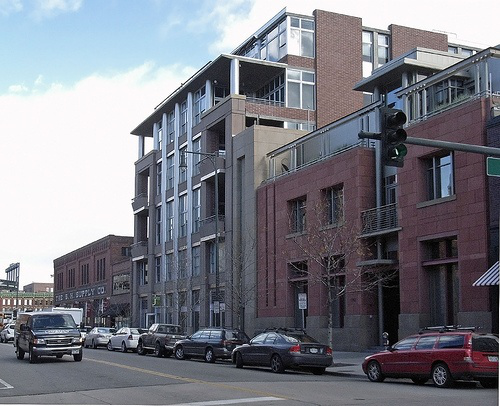

text: I can see a [MASK].
- ctrl_visual_bert [MASK]=['lot', 'city', 'building', 'view', 'hotel', 'skyscraper', 'house', 'picture', 'sign', 'photo']
- ctrl_uniter [MASK]=['lot', 'building', 'city', 'view', 'block', 'street', 'skyscraper', 'hotel', 'photo', 'house']
- ctrl_vl_bert [MASK]=['building', 'lot', 'city', 'view', 'picture', 'house', 'facade', 'photo', 'street', 'block']
- ctrl_vilbert [MASK]=['building', 'lot', 'city', 'view', 'house', 'skyscraper', 'hotel', 'sign', 'street', 'tower']
- ctrl_lxmert [MASK]=['city', 'building', 'lot', 'house', 'view', 'street', 'home', 'picture', 'hotel', 'corner']


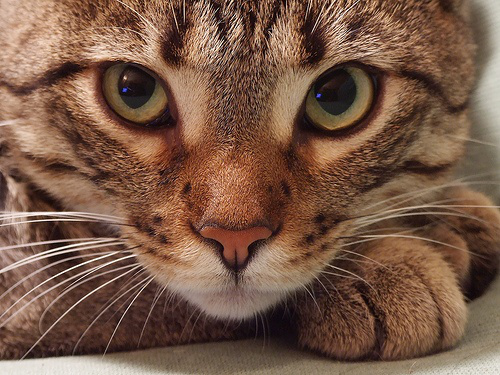

text: I can see a [MASK].
- ctrl_visual_bert [MASK]=['cat', 'tiger', 'face', 'leopard', 'difference', 'kitten', 'pattern', 'smile', 'wolf', 'thing']
- ctrl_uniter [MASK]=['tiger', 'cat', 'face', 'lion', 'leopard', 'smile', 'jaguar', 'kitten', 'wolf', 'lot']
- ctrl_vl_bert [MASK]=['cat', 'tiger', 'lot', 'face', 'leopard', 'kitten', 'wolf', 'squirrel', 'portrait', 'dog']
- ctrl_vilbert [MASK]=['tiger', 'cat', 'leopard', 'face', 'kitten', 'lion', 'wolf', 'smile', 'dog', 'jaguar']
- ctrl_lxmert [MASK]=['tiger', 'cat', 'leopard', 'jaguar', 'face', 'kitten', 'wolf', 'lion', 'tigers', 'smile']


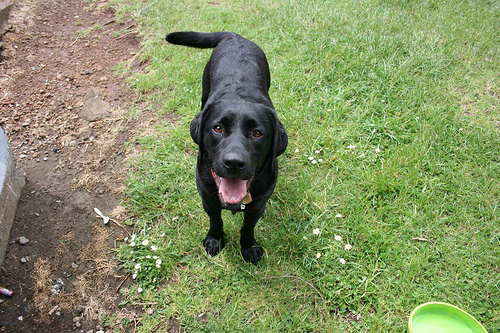

text: I can see a [MASK].
- ctrl_visual_bert [MASK]=['dog', 'puppy', 'face', 'wolf', 'black', 'smile', 'pig', 'bulldog', 'difference', 'pup']
- ctrl_uniter [MASK]=['dog', 'puppy', 'pig', 'kangaroo', 'wolf', 'goat', 'smile', 'bulldog', 'greyhound', 'mix']
- ctrl_vl_bert [MASK]=['dog', 'puppy', 'pig', 'moose', 'city', 'kangaroo', 'bear', 'lot', 'bulldog', 'face']
- ctrl_vilbert [MASK]=['dog', 'puppy', 'smile', 'bulldog', 'wolf', 'difference', 'person', 'face', 'pig', 'leash']
- ctrl_lxmert [MASK]=['dog', 'puppy', 'smile', 'wolf', 'city', 'face', 'pet', 'tiger', 'greyhound', 'bulldog']


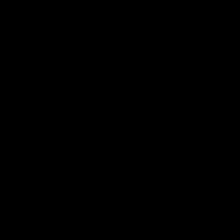

text: I can see a [MASK].
- ctrl_visual_bert [MASK]=['light', 'pattern', 'shadow', 'cloud', 'lot', 'difference', 'moon', 'city', 'line', 'tree']
- ctrl_uniter [MASK]=['light', 'pattern', 'shadow', 'line', 'cloud', 'star', 'cross', 'constellation', 'crowd', 'city']
- ctrl_vl_bert [MASK]=['lot', 'cloud', 'pattern', 'light', 'city', 'star', 'line', 'tree', 'face', 'wolf']
- ctrl_vilbert [MASK]=['light', 'lot', 'pattern', 'cloud', 'city', 'shadow', 'storm', 'wolf', 'star', 'sky']
- ctrl_lxmert [MASK]=['pattern', 'light', 'city', 'line', 'shadow', 'lot', 'wall', 'cloud', 'sky', 'galaxy']


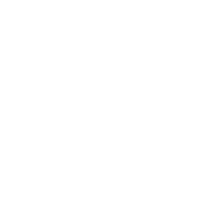

text: I can see a [MASK].
- ctrl_visual_bert [MASK]=['pattern', 'lot', 'smile', 'line', 'difference', 'thing', 'shadow', 'cloud', 'face', 'logo']
- ctrl_uniter [MASK]=['pattern', 'lot', 'line', 'smile', 'font', 'number', 'text', 'shadow', 'cloud', 'book']
- ctrl_vl_bert [MASK]=['lot', 'cloud', 'picture', 'line', 'pattern', 'city', 'tree', 'smile', 'rainbow', 'face']
- ctrl_vilbert [MASK]=['lot', 'pattern', 'line', 'smile', 'cloud', 'light', 'mirror', 'face', 'picture', 'star']
- ctrl_lxmert [MASK]=['pattern', 'line', 'lot', 'smile', 'city', 'difference', 'wall', 'mirror', 'font', 'picture']


In [7]:
for image in images:
    display(image)
    print('text:', text)
    for name, model, tokenizer in models:
        tokens = predict(model, tokenizer, image, text)
        print(f'- {name} [MASK]={tokens}')